In [ ]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.corpus import opinion_lexicon
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score
import seaborn as sns
import pandas as pd
import json

# Read-in the data

In [ ]:
# 0. Connect your Google Drive
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/INLS613/
!ls # special shell command to view the files in the home directory of the notebook environment

# 0.1 load in train and test jsonl objects and combined them into a list of json elements
df_list = []

def load_in(file_name):
    with open(file_name, 'r') as json_file:
        json_list = list(json_file)

    # 0.2 transfer json_objects into a pd df

    for json_str in json_list:
        result = json.loads(json_str)
        df = pd.DataFrame()
        for col in result:
            if str(col) == "players" or str(col) == "game_id":
                continue
            temp_list = []
            for entry in result[col]:
                temp_list.append(entry)
            df[col] = pd.Series(temp_list)
        df_list.append(df)

load_in('train.jsonl')
load_in('test.jsonl')

df = pd.concat(df_list, ignore_index = True)
df = df.dropna()

print(df.head())

Mounted at /content/gdrive
/content/gdrive/.shortcut-targets-by-id/1HDQBolrZEf9kEk3BtM9CoA6nCG47BqqG/INLS613
 combined.csv			 test.jsonl
'Final Presentation.gslides'	 TO-DO.gdoc
 nb_results			 train.jsonl
'Project Proposal.gdoc'		 train_scrubbedMinusEmotes.csv
'Project Proposal_Graded.docx'	 train_scrubbedMinusEmotes.gsheet
'Project Report.gdoc'		 wordcloud_all.png
'Test Final Project (1).gdoc'	 wordcloud_lie.png
'Test Final Project (1).pdf'	 wordcloud_truth.png
'Test Final Project.ipynb'


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


                                            messages  sender_labels  \
0  Germany!\n\nJust the person I want to speak wi...            1.0   
1  You've whet my appetite, Italy. What's the sug...            1.0   
2                                                  👍            1.0   
3  It seems like there are a lot of ways that cou...            1.0   
4  Yeah, I can’t say I’ve tried it and it works, ...            1.0   

  receiver_labels speakers receivers  absolute_message_index  \
0            True    italy   germany                    74.0   
1            True  germany     italy                    76.0   
2            True    italy   germany                    86.0   
3            True  germany     italy                    87.0   
4    NOANNOTATION    italy   germany                    89.0   

   relative_message_index seasons years game_score game_score_delta  
0                     0.0  Spring  1901          3                0  
1                     1.0  Spring  1901         

## Removing ineffective feature columns


In [ ]:
#import pandas as pd
#df = pd.read_csv("train_scrubbedMinusEmotes.csv")
#df=df.drop(columns=['Unnamed: 0','Unnamed: 12', 'Unnamed: 13','Unnamed: 14','seasons','years','speakers','receivers','receiver_labels'])
df = df.drop(columns=['seasons','years','speakers','receivers'])
df.head()

messages  sender_labels  \
0  Germany!\n\nJust the person I want to speak wi...            1.0   
1  You've whet my appetite, Italy. What's the sug...            1.0   
2                                                  👍            1.0   
3  It seems like there are a lot of ways that cou...            1.0   
4  Yeah, I can’t say I’ve tried it and it works, ...            1.0   

  receiver_labels  absolute_message_index  relative_message_index game_score  \
0            True                    74.0                     0.0          3   
1            True                    76.0                     1.0          3   
2            True                    86.0                     2.0          3   
3            True                    87.0                     3.0          3   
4    NOANNOTATION                    89.0                     4.0          3   

  game_score_delta  
0                0  
1                0  
2                0  
3                0  
4                0

## Calculate Sender Accuracy and prec (overall)



> Indented block



In [ ]:
def human_test(df):
  true_all = 0
  total = 0

  true_lie = 0
  false_lie = 0
  for i, row in df.iterrows():
    r_lab = row["receiver_labels"]
    if r_lab == "NOANNOTATION":
      continue
    else:
      if bool(row['sender_labels']) == row['receiver_labels']:
        true_all += 1
    total += 1
    if bool(row['sender_labels']) == False and row['receiver_labels'] == False:
      true_lie += 1
    if bool(row['sender_labels']) == False and row['receiver_labels'] == True:
      false_lie += 1

  accuracy_receiver_total = true_all / total
  print(f"The accuracy for humans is: {accuracy_receiver_total}")

  prec_receiver_total = true_lie / (true_lie + false_lie)
  print(f"The precision for humans is: {prec_receiver_total}")
  prec_receiver_total

human_test(df)

The accuracy for humans is: 0.9124827586206896
The precision for humans is: 0.1422872340425532


# Feature Generation

## Gather all the 'False' class and downsampling the 'True' class for a total sample size of 1662 (50-50 split)

In [ ]:
false=df[df['sender_labels']==False]
false

messages  sender_labels  \
132    I really don’t think that’s a fair description...            0.0   
135    We’re friends, right? I believe that every sin...            0.0   
139    I have to say that I’m surprised that you feel...            0.0   
144     Here’s the deal: I like you better than England.            0.0   
158    But I don’t think there is anything wrong with...            0.0   
...                                                  ...            ...   
15836  You are obviously not allied with Italy. I don...            0.0   
15847  He's angry at me- so not sure how helpful he w...            0.0   
15851  I think the point where I stop making any prog...            0.0   
15861                 There's no solo in sight right now            0.0   
15868  Interesting, I didn't mean to take Naples- I f...            0.0   

      receiver_labels  absolute_message_index  relative_message_index  \
132              True                  1517.0                   132.0   
135              True                  1521.0                   135.0   
139              True                  1535.0                   139.0   
144              True                  1548.0                   144.0   
158              True                  1582.0                   158.0   
...               ...                     ...                     ...   
15836            True                  1210.0                    50.0   
15847            True                  1260.0                    61.0   
15851            True                  1327.0                    65.0   
15861           False                  1419.0                    75.0   
15868            True                  1498.0                    82.0   

      game_score game_score_delta  
132            8                3  
135            8                3  
139            8                3  
144            8                3  
158            8                3  
...          ...              ...  
15836          9                4  
15847         12                6  
15851         12                6  
15861         15                8  
15868         15                8  

[831 rows x 7 columns]

In [ ]:
true=df[df['sender_labels']==True]
true = true.sample(n = false.shape[0], random_state=1)
true

messages  sender_labels  \
5700                             You're not doing badly!            1.0   
12361  I was definitely thinking of going after Franc...            1.0   
4472   I mean... I could be interested but I need som...            1.0   
11894  God if only you knew how complicated things ar...            1.0   
1729           I am. And it stays between us, of course.            1.0   
...                                                  ...            ...   
6683   Helping Italy with Piedmont. You're probably f...            1.0   
2823   I mean, you may already be thinking this, but ...            1.0   
12348                       Not sure what you mean there            1.0   
11123                                  God the Turks ugh            1.0   
3811   What did he agree to do?  Asking so I can hold...            1.0   

      receiver_labels  absolute_message_index  relative_message_index  \
5700             True                  1231.0                    55.0   
12361    NOANNOTATION                    28.0                     2.0   
4472             True                  2445.0                   379.0   
11894            True                  1123.0                    83.0   
1729             True                  2043.0                   440.0   
...               ...                     ...                     ...   
6683     NOANNOTATION                   788.0                    30.0   
2823     NOANNOTATION                  1577.0                   205.0   
12348            True                   482.0                    47.0   
11123            True                  1353.0                   299.0   
3811     NOANNOTATION                  1423.0                    77.0   

      game_score game_score_delta  
5700           5                0  
12361          3                0  
4472           9                1  
11894          6                1  
1729           7                2  
...          ...              ...  
6683           4                0  
2823           5               -2  
12348          4               -2  
11123          7                2  
3811           4               -1  

[831 rows x 7 columns]

In [ ]:
final = true.append(false)
final = final.reset_index(drop=True)
final = final.sample(frac=1)
final

messages  sender_labels  \
1507                                Alright. Understood            0.0   
663   I'm always happy to listen to offers. What wer...            1.0   
1573  Hey so I ended up going to the black sea defen...            0.0   
890                             Good. Consider it done.            0.0   
1449  Yeah you have before.  We both have. I guess I...            0.0   
...                                                 ...            ...   
481   You could take him down together, unless he's ...            1.0   
359                                Cool. Let’s do this.            1.0   
864   Ha! No I don’t. I’d imagine he is coming for m...            0.0   
803   I agree with the DMZ -- I definitely think we ...            1.0   
1103                               You taking Mos here?            0.0   

     receiver_labels  absolute_message_index  relative_message_index  \
1507            True                   454.0                    66.0   
663             True                   434.0                    26.0   
1573    NOANNOTATION                   196.0                     6.0   
890     NOANNOTATION                   586.0                    41.0   
1449           False                   946.0                   385.0   
...              ...                     ...                     ...   
481             True                   232.0                     5.0   
359             True                   774.0                    70.0   
864             True                  2147.0                   271.0   
803             True                   103.0                     5.0   
1103            True                  1753.0                    21.0   

     game_score game_score_delta  
1507          5                1  
663           5                0  
1573          3               -1  
890           5                0  
1449         13                2  
...         ...              ...  
481           5                1  
359           5                0  
864          10                3  
803           3                0  
1103          6                1  

[1662 rows x 7 columns]

### Get Human Metrics for Sample

In [ ]:
final_sender = final
human_test(final_sender)
final = final.drop(columns=["receiver_labels"])
final

The accuracy for humans is: 0.5459387483355526
The precision for humans is: 0.1422872340425532


messages  sender_labels  \
1507                                Alright. Understood            0.0   
663   I'm always happy to listen to offers. What wer...            1.0   
1573  Hey so I ended up going to the black sea defen...            0.0   
890                             Good. Consider it done.            0.0   
1449  Yeah you have before.  We both have. I guess I...            0.0   
...                                                 ...            ...   
481   You could take him down together, unless he's ...            1.0   
359                                Cool. Let’s do this.            1.0   
864   Ha! No I don’t. I’d imagine he is coming for m...            0.0   
803   I agree with the DMZ -- I definitely think we ...            1.0   
1103                               You taking Mos here?            0.0   

      absolute_message_index  relative_message_index game_score  \
1507                   454.0                    66.0          5   
663                    434.0                    26.0          5   
1573                   196.0                     6.0          3   
890                    586.0                    41.0          5   
1449                   946.0                   385.0         13   
...                      ...                     ...        ...   
481                    232.0                     5.0          5   
359                    774.0                    70.0          5   
864                   2147.0                   271.0         10   
803                    103.0                     5.0          3   
1103                  1753.0                    21.0          6   

     game_score_delta  
1507                1  
663                 0  
1573               -1  
890                 0  
1449                2  
...               ...  
481                 1  
359                 0  
864                 3  
803                 0  
1103                1  

[1662 rows x 6 columns]

Flip Sender Values

In [ ]:
#Now need to flip the sender_labels to use precision values. Lies are now postive case

for i, row in final.iterrows():
  if row["sender_labels"] == 0.0:
    final.at[i,"sender_labels"] = 1.0
  else:
    final.at[i,"sender_labels"] = 0.0

final.head()

messages  sender_labels  \
1507                                Alright. Understood            1.0   
663   I'm always happy to listen to offers. What wer...            0.0   
1573  Hey so I ended up going to the black sea defen...            1.0   
890                             Good. Consider it done.            1.0   
1449  Yeah you have before.  We both have. I guess I...            1.0   

      absolute_message_index  relative_message_index game_score  \
1507                   454.0                    66.0          5   
663                    434.0                    26.0          5   
1573                   196.0                     6.0          3   
890                    586.0                    41.0          5   
1449                   946.0                   385.0         13   

     game_score_delta  
1507                1  
663                 0  
1573               -1  
890                 0  
1449                2

##Adding Psycholinguistic features

In [ ]:
#Initalizing various lists 
import nltk
nltk.download('opinion_lexicon')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')


#use opinion lexicion from NLTK for sentiment 
sense_words = set(['see', 'sense', 'appearance', 'smell', 'bittersweet', 'dull', 
               'dim', 'gloomy', 'grand', 'bright', 'dismal', 'massive', 'neat', 
               'pop', 'tear', 'cry', 'deaf', 'murmur', 'explode', 'hush', 
               'firm', 'rocky', 'cold', 'solid', 'narrow', 'delicate', 'stale', 
               'sweaty', 'robust', 'delicious', 'tempting', 'replusive', 
               'appealing', 'appetizing', 'tantalizing', 'spoiled'])
motion_words = set(['arrive', 'run', 'walk', 'move', 'attack', 'defend', 'claim', 
                'capture', 'hold', 'sprint', 'sail', 'maneuver', 'advance', 
                'retreat', 'go'])    
exclusion_words = set(['but', 'without', 'exclude', 'except', 'only', 'just', 
                   'either'])
self_reference_words = set(['i', 'me', 'my', 'mine', 'we', 'ours'])
hesitations_words = set(['um', 'er', 'uh', 'hmm', 'ah'])
hedge_words = set(['perhaps', 'maybe', 'admittedly', 'might', 'possibly', 'likely', 
               'probably', 'predominantly', 'presumably', 'seems', 'appears', 
               'may', 'suggests', 'sometimes', 'often', 'around', 'roughly', 
               'fairly', 'usually'])
negation_words = set(['never', 'no', 'nothing', 'nowhere', 'noone', 'none', 'not', 
                  'havent', 'hasnt', 'hadnt', 'cant', 'couldnt', 'shouldnt', 
                  'wont', 'wouldnt', 'dont', 'doesnt', 'didnt', 'isnt', 'arent',
                  'aint'])
pos_words = set(opinion_lexicon.positive())
neg_words = set(opinion_lexicon.negative())
#negation_words -- pull from NLTK sentiment ult 

psycholing_features = final


psycholing_features.head()

[nltk_data] Downloading package opinion_lexicon to /root/nltk_data...
[nltk_data]   Unzipping corpora/opinion_lexicon.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


messages  sender_labels  \
1507                                Alright. Understood            1.0   
663   I'm always happy to listen to offers. What wer...            0.0   
1573  Hey so I ended up going to the black sea defen...            1.0   
890                             Good. Consider it done.            1.0   
1449  Yeah you have before.  We both have. I guess I...            1.0   

      absolute_message_index  relative_message_index game_score  \
1507                   454.0                    66.0          5   
663                    434.0                    26.0          5   
1573                   196.0                     6.0          3   
890                    586.0                    41.0          5   
1449                   946.0                   385.0         13   

     game_score_delta  
1507                1  
663                 0  
1573               -1  
890                 0  
1449                2

In [ ]:
from collections import Counter
import string


for i, row in psycholing_features.iterrows():
  sense_words_count = 0
  pos_words_count = 0
  neg_words_count = 0
  motion_words_count = 0
  exclusion_words_count = 0
  self_reference_words_count = 0
  hesitations_words_count = 0
  hedge_words_count = 0
  negation_words_count = 0
  words_greater_six_count = 0
  
  message = row["messages"]
  message = message.lower()
  message = message.translate(str.maketrans('', '', string.punctuation)) #remove punc
  message = message.split()
  message_unique = list(set(message))
  if len(message) > 0:
    message_TTR = len(message_unique) / len(message) # calcuate type token ratio
  else:
    message_TTR = 0

  for word in message:
    if word in pos_words:
      pos_words_count += 1
    elif word in neg_words:
      neg_words_count += 1
    if word in sense_words: # will refactor to look nice
      sense_words_count += 1
    if word in motion_words:
      motion_words_count += 1
    if word in exclusion_words:
      exclusion_words_count += 1
    if word in self_reference_words:
      self_reference_words_count += 1
    if word in hesitations_words:
      hesitations_words_count += 1
    if word in hedge_words:
      hedge_words_count += 1
    if word in negation_words:
      negation_words_count += 1
    if len(word) > 6:
      words_greater_six_count += 1

  tokens = message
  text = nltk.Text(tokens)
  tagged_text = nltk.pos_tag(text, tagset='universal')
  counts = Counter(tag for word,tag in tagged_text) # get count of each part of speech found

  psycholing_features.at[i, "positive_word_count"] = pos_words_count  #will refactor later to look nice
  psycholing_features.at[i,"negative_word_count"] = neg_words_count
  psycholing_features.at[i,"sense_words_count"] = sense_words_count
  psycholing_features.at[i,"motion_words_count"] = motion_words_count
  psycholing_features.at[i,"exclusion_words_count"] = exclusion_words_count
  psycholing_features.at[i,"self_reference_words_count"] = self_reference_words_count
  psycholing_features.at[i,"hesitations_words_count"] = hesitations_words_count
  psycholing_features.at[i,"hedge_words_count"] = hedge_words_count
  psycholing_features.at[i,"negation_words_count"] = negation_words_count
  psycholing_features.at[i,"words_greater_six_count"] = words_greater_six_count
  psycholing_features.at[i,"TTR"] = message_TTR
  psycholing_features.at[i,"pronoun_count"] = counts["PRON"]
  psycholing_features.at[i,"adjective_count"] = counts["ADJ"]
  psycholing_features.at[i,"noun_count"] = counts["NOUN"]
  psycholing_features.at[i,"verb_count"] = counts["VERB"]
  psycholing_features.at[i,"conjuction_count"] = counts["CONJ"]
  psycholing_features.at[i,"preposition_count"] = counts["ADP"]
  psycholing_features.at[i,"adverb_count"] = counts["ADV"]

psycholing_features.head()

messages  sender_labels  \
1507                                Alright. Understood            1.0   
663   I'm always happy to listen to offers. What wer...            0.0   
1573  Hey so I ended up going to the black sea defen...            1.0   
890                             Good. Consider it done.            1.0   
1449  Yeah you have before.  We both have. I guess I...            1.0   

      absolute_message_index  relative_message_index game_score  \
1507                   454.0                    66.0          5   
663                    434.0                    26.0          5   
1573                   196.0                     6.0          3   
890                    586.0                    41.0          5   
1449                   946.0                   385.0         13   

     game_score_delta  positive_word_count  negative_word_count  \
1507                1                  0.0                  0.0   
663                 0                  1.0                  0.0   
1573               -1                  1.0                  2.0   
890                 0                  1.0                  0.0   
1449                2                  1.0                  1.0   

      sense_words_count  motion_words_count  ...  negation_words_count  \
1507                0.0                 0.0  ...                   0.0   
663                 0.0                 0.0  ...                   0.0   
1573                0.0                 1.0  ...                   1.0   
890                 0.0                 0.0  ...                   0.0   
1449                0.0                 0.0  ...                   0.0   

      words_greater_six_count       TTR  pronoun_count  adjective_count  \
1507                      2.0  1.000000            0.0              0.0   
663                       1.0  0.909091            2.0              1.0   
1573                     14.0  0.756098           11.0              5.0   
890                       1.0  1.000000            1.0              1.0   
1449                      3.0  0.870968            2.0              2.0   

      noun_count  verb_count  conjuction_count  preposition_count  \
1507         1.0         0.0               0.0                0.0   
663          1.0         4.0               0.0                0.0   
1573        13.0        20.0               1.0               13.0   
890          0.0         2.0               0.0                0.0   
1449         9.0         5.0               1.0                4.0   

      adverb_count  
1507           1.0  
663            1.0  
1573           8.0  
890            0.0  
1449           3.0  

[5 rows x 24 columns]

In [ ]:
psycholing_features = psycholing_features.drop(columns=["messages", 'absolute_message_index', "sender_labels", "relative_message_index", "game_score", "game_score_delta"])
psycholing_features.head()

positive_word_count  negative_word_count  sense_words_count  \
1507                  0.0                  0.0                0.0   
663                   1.0                  0.0                0.0   
1573                  1.0                  2.0                0.0   
890                   1.0                  0.0                0.0   
1449                  1.0                  1.0                0.0   

      motion_words_count  exclusion_words_count  self_reference_words_count  \
1507                 0.0                    0.0                         0.0   
663                  0.0                    0.0                         0.0   
1573                 1.0                    1.0                         5.0   
890                  0.0                    0.0                         0.0   
1449                 0.0                    0.0                         3.0   

      hesitations_words_count  hedge_words_count  negation_words_count  \
1507                      0.0                0.0                   0.0   
663                       0.0                0.0                   0.0   
1573                      0.0                0.0                   1.0   
890                       0.0                0.0                   0.0   
1449                      0.0                0.0                   0.0   

      words_greater_six_count       TTR  pronoun_count  adjective_count  \
1507                      2.0  1.000000            0.0              0.0   
663                       1.0  0.909091            2.0              1.0   
1573                     14.0  0.756098           11.0              5.0   
890                       1.0  1.000000            1.0              1.0   
1449                      3.0  0.870968            2.0              2.0   

      noun_count  verb_count  conjuction_count  preposition_count  \
1507         1.0         0.0               0.0                0.0   
663          1.0         4.0               0.0                0.0   
1573        13.0        20.0               1.0               13.0   
890          0.0         2.0               0.0                0.0   
1449         9.0         5.0               1.0                4.0   

      adverb_count  
1507           1.0  
663            1.0  
1573           8.0  
890            0.0  
1449           3.0

## Apply TF-IDF vectorizer

### Generate stop word dictionary specific to the dataset

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
df_sw = pd.read_csv("train_scrubbedMinusEmotes.csv")
speaker_unique = df_sw['speakers'].unique()
stop = stopwords.words('english') + speaker_unique.tolist()
stop

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

### Apply TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

v = TfidfVectorizer(ngram_range=(1,1),stop_words=stop)
text = v.fit_transform(final['messages'])

text_rep = pd.DataFrame(text.toarray(), columns=v.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Combining all the features repersentation configurations and target together

In [ ]:
error_df = final.drop(columns = ["absolute_message_index",	"relative_message_index",	"game_score",	"game_score_delta"])
final_drop=final.drop(columns=['messages'])
combined = pd.concat([text_rep, psycholing_features, final_drop], axis=1,join='inner')
TFIDF_psycho = pd.concat([text_rep, psycholing_features], axis=1,join='inner')
psycho_final = pd.concat([psycholing_features, final_drop], axis=1,join='inner')
TFIDF_final = pd.concat([text_rep, final_drop], axis=1,join='inner')

TFIDF_psycho["sender_labels"] = final["sender_labels"]
configuations = [combined, TFIDF_psycho, psycho_final, TFIDF_final]
error_df.head()

messages  sender_labels  \
1507                                Alright. Understood            1.0   
663   I'm always happy to listen to offers. What wer...            0.0   
1573  Hey so I ended up going to the black sea defen...            1.0   
890                             Good. Consider it done.            1.0   
1449  Yeah you have before.  We both have. I guess I...            1.0   

      positive_word_count  negative_word_count  sense_words_count  \
1507                  0.0                  0.0                0.0   
663                   1.0                  0.0                0.0   
1573                  1.0                  2.0                0.0   
890                   1.0                  0.0                0.0   
1449                  1.0                  1.0                0.0   

      motion_words_count  exclusion_words_count  self_reference_words_count  \
1507                 0.0                    0.0                         0.0   
663                  0.0                    0.0                         0.0   
1573                 1.0                    1.0                         5.0   
890                  0.0                    0.0                         0.0   
1449                 0.0                    0.0                         3.0   

      hesitations_words_count  hedge_words_count  negation_words_count  \
1507                      0.0                0.0                   0.0   
663                       0.0                0.0                   0.0   
1573                      0.0                0.0                   1.0   
890                       0.0                0.0                   0.0   
1449                      0.0                0.0                   0.0   

      words_greater_six_count       TTR  pronoun_count  adjective_count  \
1507                      2.0  1.000000            0.0              0.0   
663                       1.0  0.909091            2.0              1.0   
1573                     14.0  0.756098           11.0              5.0   
890                       1.0  1.000000            1.0              1.0   
1449                      3.0  0.870968            2.0              2.0   

      noun_count  verb_count  conjuction_count  preposition_count  \
1507         1.0         0.0               0.0                0.0   
663          1.0         4.0               0.0                0.0   
1573        13.0        20.0               1.0               13.0   
890          0.0         2.0               0.0                0.0   
1449         9.0         5.0               1.0                4.0   

      adverb_count  
1507           1.0  
663            1.0  
1573           8.0  
890            0.0  
1449           3.0

# Exploratory Data Analysis

## Word cloud using data from both target class

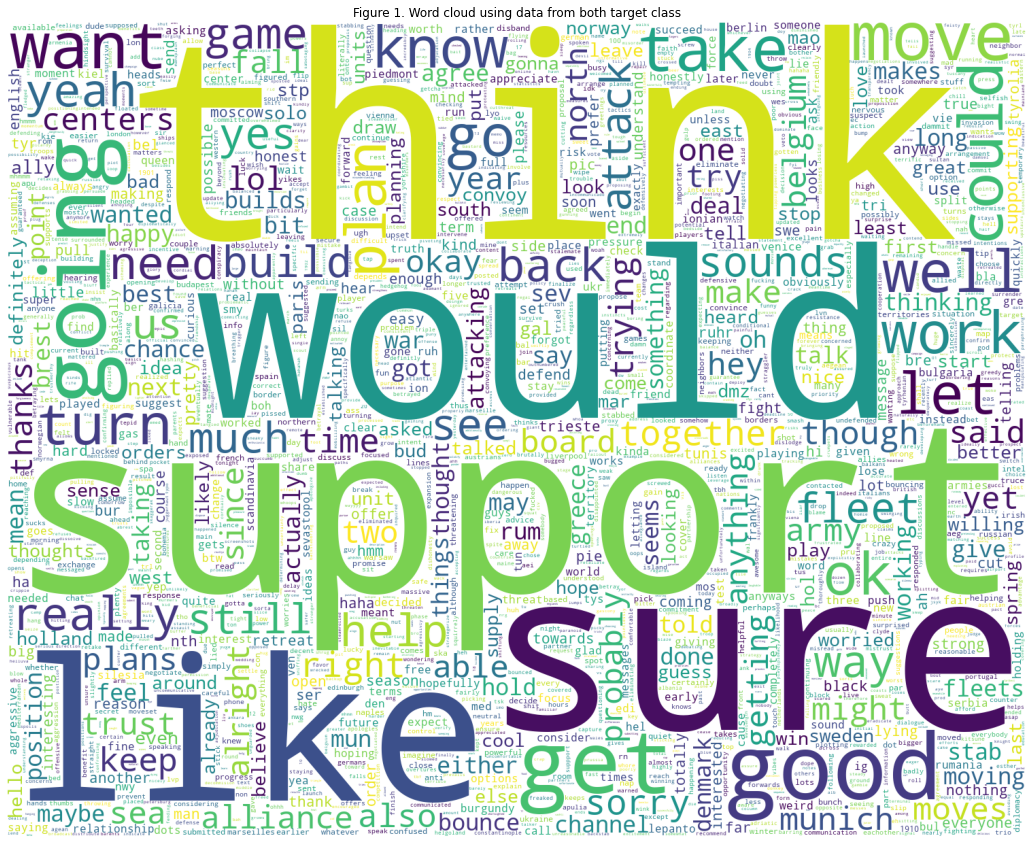

In [ ]:
#v.vocabulary_.items()
tfidf_weights = [(word, text.getcol(idx).sum()) for word, idx in v.vocabulary_.items()]
#tfidf_weights[0:10]
w = WordCloud(width=1500, height=1200, mode='RGBA', background_color='white', max_words=2000).fit_words(dict(tfidf_weights))
plt.figure(figsize=(20,15))
plt.imshow(w)
plt.axis('off')
plt.title("Figure 1. Word cloud using data from both target class")
plt.savefig('wordcloud_all.png')

## Word cloud for truth only

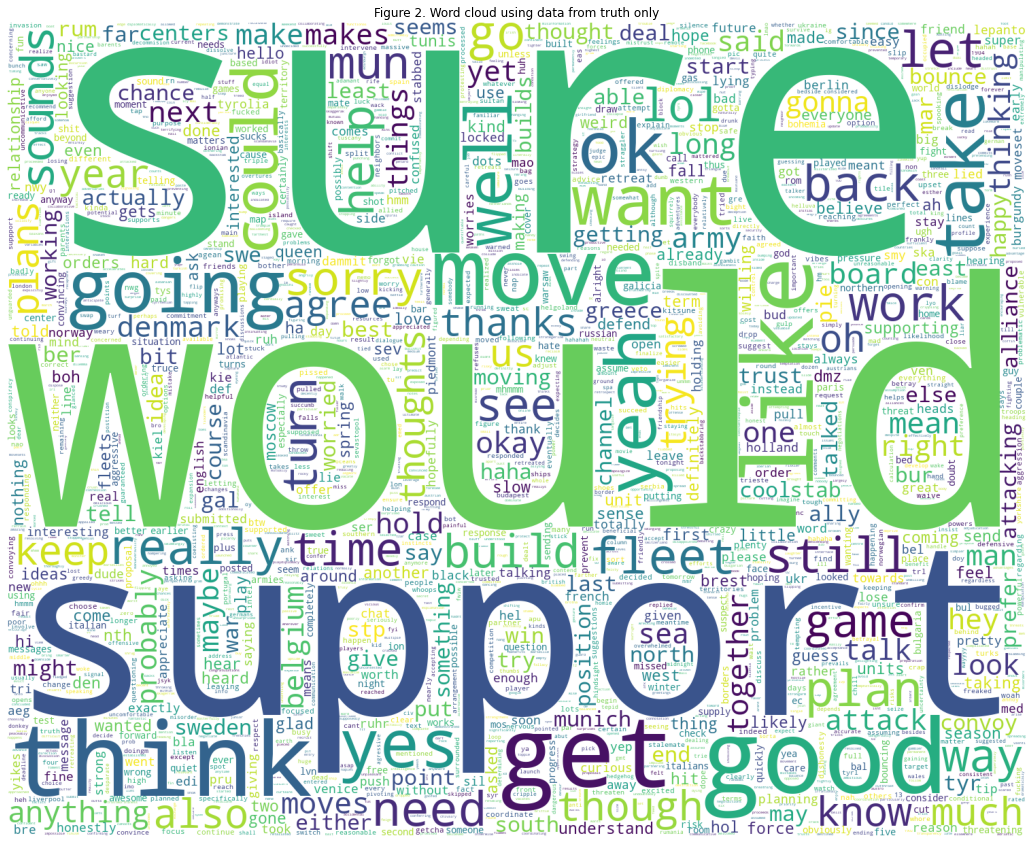

In [ ]:
v_t = TfidfVectorizer(ngram_range=(1,1),stop_words=stop)
text_t = v_t.fit_transform(true['messages'])

tfidf_weights_t = [(word, text_t.getcol(idx).sum()) for word, idx in v_t.vocabulary_.items()]

w_t = WordCloud(width=1500, height=1200, mode='RGBA', background_color='white', max_words=2000).fit_words(dict(tfidf_weights_t))
plt.figure(figsize=(20,15))
plt.imshow(w_t)
plt.axis('off')
plt.title("Figure 2. Word cloud using data from truth only")
plt.savefig('wordcloud_truth.png')


In [ ]:
combined.to_csv("combined.csv")

## Word cloud for lie only

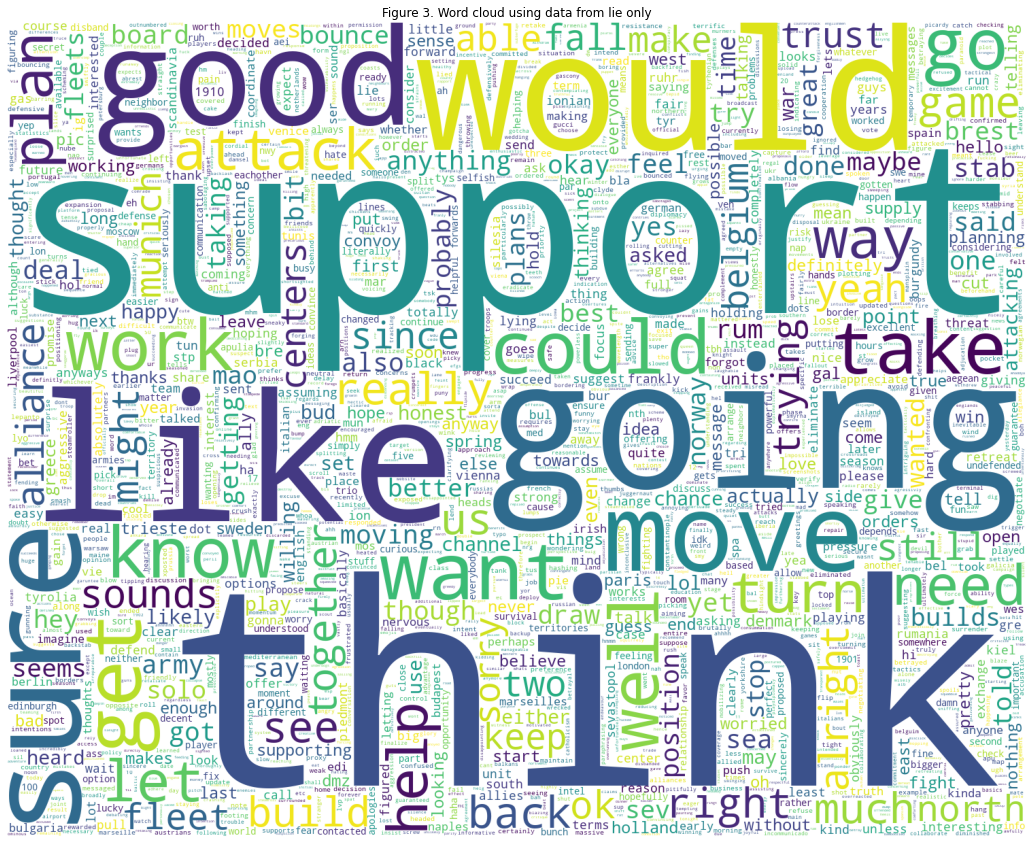

In [ ]:
v_f = TfidfVectorizer(ngram_range=(1,1),stop_words=stop)
text_f = v_f.fit_transform(false['messages'])

tfidf_weights_f = [(word, text_f.getcol(idx).sum()) for word, idx in v_f.vocabulary_.items()]

w_f = WordCloud(width=1500, height=1200, mode='RGBA', background_color='white', max_words=2000).fit_words(dict(tfidf_weights_f))
plt.figure(figsize=(20,15))
plt.imshow(w_f)
plt.axis('off')
plt.title("Figure 3. Word cloud using data from lie only")
plt.savefig('wordcloud_lie.png')


## Distribution Comparison

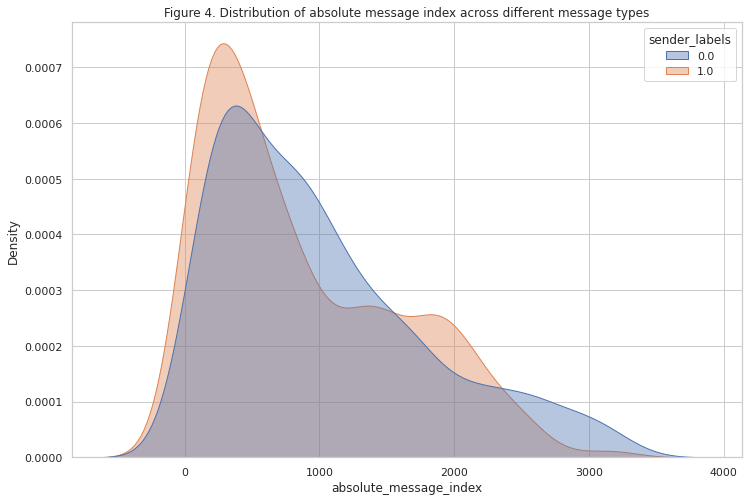

In [ ]:
plt.rcParams["figure.figsize"]=12,8

# set seaborn whitegrid theme
sns.set(style="whitegrid")

# Without transparency
sns.kdeplot(data=combined, x="absolute_message_index", hue="sender_labels", fill=True, common_norm=False, alpha=0.4)
plt.title("Figure 4. Distribution of absolute message index across different message types")
plt.show()

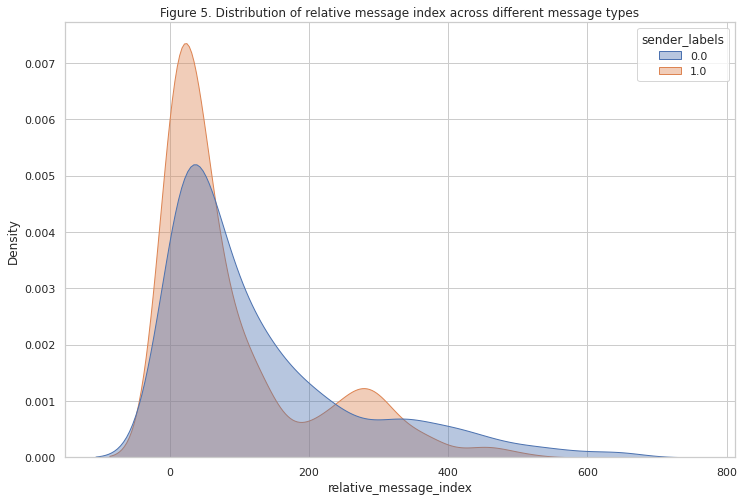

In [ ]:
plt.rcParams["figure.figsize"]=12,8

# set seaborn whitegrid theme
sns.set(style="whitegrid")

# Without transparency
sns.kdeplot(data=combined, x="relative_message_index", hue="sender_labels", fill=True, common_norm=False, alpha=0.4)
plt.title("Figure 5. Distribution of relative message index across different message types")
plt.show()

# Predictive Modeling

## Splitting features and target

In [ ]:
import numpy as np

input = TFIDF_final.sample(frac=1)

X_train = input.drop(columns=['sender_labels'])
X_train_array = X_train.to_numpy()
#X_train_array
input['label'] = np.where(input['sender_labels'] == False, 1, 0)
curr_trans = input.drop(columns=['sender_labels'])
curr_trans

Y_train = curr_trans['label']
Y_train_array = Y_train.to_numpy()

input.head()
#Y_train_array



01   02   03   05   10  100   11   12   13   14  ...  \
332  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
862  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
981  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
912  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
505  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   

     words_greater_six_count       TTR  pronoun_count  adjective_count  \
332                      2.0  0.888889            1.0              4.0   
862                      3.0  0.846154            0.0              3.0   
981                     19.0  0.706767           12.0             11.0   
912                      0.0  1.000000            2.0              1.0   
505                      4.0  1.000000            0.0              3.0   

     noun_count  verb_count  conjuction_count  preposition_count  \
332         5.0         2.0               0.0                7.0   
862         4.0         3.0               2.0                0.0   
981        26.0        30.0              10.0               13.0   
912         2.0         3.0               0.0                2.0   
505         7.0         2.0               1.0                4.0   

     adverb_count  label  
332           4.0      1  
862           0.0      0  
981          12.0      0  
912           1.0      0  
505           0.0      1  

[5 rows x 2967 columns]

## Logistic Regression

### Testing logistic regression model performance via cross validation

In [ ]:
from sklearn.metrics import average_precision_score as a_p_s
from sklearn.model_selection import cross_val_predict

log_reg = LogisticRegression(penalty='l2',C = 50, solver='liblinear')
k_folds = KFold(n_splits = 5)
scores = cross_val_score(log_reg, X_train_array, Y_train_array, cv = k_folds)
precision = cross_val_score(log_reg, X_train_array, Y_train_array, cv = k_folds, scoring="precision_macro")

# error_df["game_psycho_predict"] = cross_val_predict(log_reg, X_train_array, Y_train_array, cv = k_folds)

print('Cross-Validation precision Scores', precision)
print('Cross-Validation Accuracy Scores', scores)

Cross-Validation precision Scores [0.65469145 0.61065751 0.63497738 0.60678591 0.66808449]
Cross-Validation Accuracy Scores [0.65465465 0.60960961 0.63253012 0.60240964 0.6686747 ]


In [ ]:
scores = pd.Series(scores)
print(' Cross-Validation Accuracy Scores Min', scores.min(),'\n Cross-Validation Accuracy Scores Mean',scores.mean(),'\n Cross-Validation Accuracy Scores Max',scores.max())
precision = pd.Series(precision)
print(' Cross-Validation Precision Scores Min', precision.min(),'\n Cross-Validation Precision Scores Mean',precision.mean(),'\n Cross-Validation Precision Scores Max',precision.max())

 Cross-Validation Accuracy Scores Min 0.6024096385542169 
 Cross-Validation Accuracy Scores Mean 0.6335757444191179 
 Cross-Validation Accuracy Scores Max 0.6686746987951807
 Cross-Validation Precision Scores Min 0.6067859118569057 
 Cross-Validation Precision Scores Mean 0.6350393486384288 
 Cross-Validation Precision Scores Max 0.6680844875849783


### Testing logistic regression model performance on the training set

In [ ]:
log_reg.fit(X_train_array, Y_train_array)
Y_hat = log_reg.predict(X_train_array)
accuracy = accuracy_score(Y_train_array, Y_hat)
print ('Regularized logistic regression, accuracy on training set:', accuracy)

Regularized logistic regression, accuracy on training set: 0.9687123947051745


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


## Naive Bayes

### Testing naive bayes classifier via cross validation

In [ ]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.model_selection import KFold, cross_val_score
nb = GaussianNB()
k_folds = KFold(n_splits = 5)
scores = cross_val_score(nb, X_train_array, Y_train_array, cv = k_folds)
precision = cross_val_score(nb, X_train_array, Y_train_array, cv = k_folds, scoring="precision_macro")
print('Cross-Validation precision Scores', precision)
print('Cross-Validation Accuracy Scores', scores)



Cross-Validation precision Scores [0.50555032 0.51086241 0.45161894 0.53187135 0.52656794]
Cross-Validation Accuracy Scores [0.5045045  0.51651652 0.45783133 0.53012048 0.52710843]


In [ ]:
from sklearn.model_selection import cross_val_predict
scores = pd.Series(scores)
print(' Cross-Validation Accuracy Scores Min', scores.min(),'\n Cross-Validation Accuracy Scores Mean',scores.mean(),'\n Cross-Validation Accuracy Scores Max',scores.max())
precision = pd.Series(precision)
print(' Cross-Validation Precision Scores Min', precision.min(),'\n Cross-Validation Precision Scores Mean',precision.mean(),'\n Cross-Validation Precision Scores Max',precision.max())



 Cross-Validation Accuracy Scores Min 0.4578313253012048 
 Cross-Validation Accuracy Scores Mean 0.5072162523969752 
 Cross-Validation Accuracy Scores Max 0.5301204819277109
 Cross-Validation Precision Scores Min 0.45161894067003555 
 Cross-Validation Precision Scores Mean 0.5052941910072498 
 Cross-Validation Precision Scores Max 0.5318713450292398


### Testing naive bayes classifier on training set

In [ ]:
nb.fit(X_train_array, Y_train_array)
Y_hat = nb.predict(X_train_array)
accuracy = accuracy_score(Y_train_array, Y_hat)
print ('naive bayes classifier, accuracy on training set:', accuracy)

naive bayes classifier, accuracy on training set: 0.8802647412755716


## Support Vector Machine

### Testing support vector classifier via cross validation

In [ ]:
from sklearn.svm import LinearSVC
SVC = LinearSVC(C=55, dual = False)
k_folds = KFold(n_splits = 5)
scores = cross_val_score(SVC, X_train_array, Y_train_array, cv = k_folds)
precision = cross_val_score(SVC, X_train_array, Y_train_array, cv = k_folds, scoring="precision_macro")
print('Cross-Validation precision Scores', precision)
print('Cross-Validation Accuracy Scores', scores)

Cross-Validation precision Scores [0.58979791 0.55522604 0.53028488 0.59661731 0.60068346]
Cross-Validation Accuracy Scores [0.58858859 0.55255255 0.53012048 0.59638554 0.60240964]


In [ ]:
scores = pd.Series(scores)
print(' Cross-Validation Accuracy Scores Min', scores.min(),'\n Cross-Validation Accuracy Scores Mean',scores.mean(),'\n Cross-Validation Accuracy Scores Max',scores.max())
precision = pd.Series(precision)
print(' Cross-Validation Precision Scores Min', precision.min(),'\n Cross-Validation Precision Scores Mean',precision.mean(),'\n Cross-Validation Precision Scores Max',precision.max())

 Cross-Validation Accuracy Scores Min 0.5301204819277109 
 Cross-Validation Accuracy Scores Mean 0.5740113607583487 
 Cross-Validation Accuracy Scores Max 0.6024096385542169
 Cross-Validation Precision Scores Min 0.5302848847759027 
 Cross-Validation Precision Scores Mean 0.5745219212719042 
 Cross-Validation Precision Scores Max 0.6006834623913913


### Testing support vector classifier on training set

In [ ]:
SVC.fit(X_train_array, Y_train_array)
Y_hat = SVC.predict(X_train_array)
accuracy = accuracy_score(Y_train_array, Y_hat)
print ('support vector classifier, accuracy on training set:', accuracy)

support vector classifier, accuracy on training set: 0.9819494584837545


## KNN

### Testing KNN via cross validation

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)
k_folds = KFold(n_splits = 5)
scores = cross_val_score(knn, X_train_array, Y_train_array, cv = k_folds)
precision = cross_val_score(knn, X_train_array, Y_train_array, cv = k_folds, scoring="precision_macro")
print('Cross-Validation precision Scores', precision)
print('Cross-Validation Accuracy Scores', scores)
error_df["tfdif_game_predict"] = cross_val_predict(knn, X_train_array, Y_train_array, cv = k_folds)

Cross-Validation precision Scores [0.63061828 0.59789222 0.64299253 0.59461298 0.62342542]
Cross-Validation Accuracy Scores [0.63063063 0.5975976  0.64156627 0.59337349 0.62349398]


In [ ]:
scores = pd.Series(scores)
print(' Cross-Validation Accuracy Scores Min', scores.min(),'\n Cross-Validation Accuracy Scores Mean',scores.mean(),'\n Cross-Validation Accuracy Scores Max',scores.max())
precision = pd.Series(precision)
print(' Cross-Validation Precision Scores Min', precision.min(),'\n Cross-Validation Precision Scores Mean',precision.mean(),'\n Cross-Validation Precision Scores Max',precision.max())

 Cross-Validation Accuracy Scores Min 0.5813253012048193 
 Cross-Validation Accuracy Scores Mean 0.606487210101668 
 Cross-Validation Accuracy Scores Max 0.6276276276276276
 Cross-Validation Precision Scores Min 0.5766843971631206 
 Cross-Validation Precision Scores Mean 0.6053772075261261 
 Cross-Validation Precision Scores Max 0.6282139245991623


### Testing KNN on training set

In [ ]:
knn.fit(X_train_array, Y_train_array)
Y_hat = knn.predict(X_train_array)
accuracy = accuracy_score(Y_train_array, Y_hat)
print ('KNN, accuracy on training set:', accuracy)

KNN, accuracy on training set: 0.7996389891696751


In [ ]:
error_df.head()
error_df.to_csv("error.csv")